5347.200256614292
traditional driving time used: 0.14299654960632324


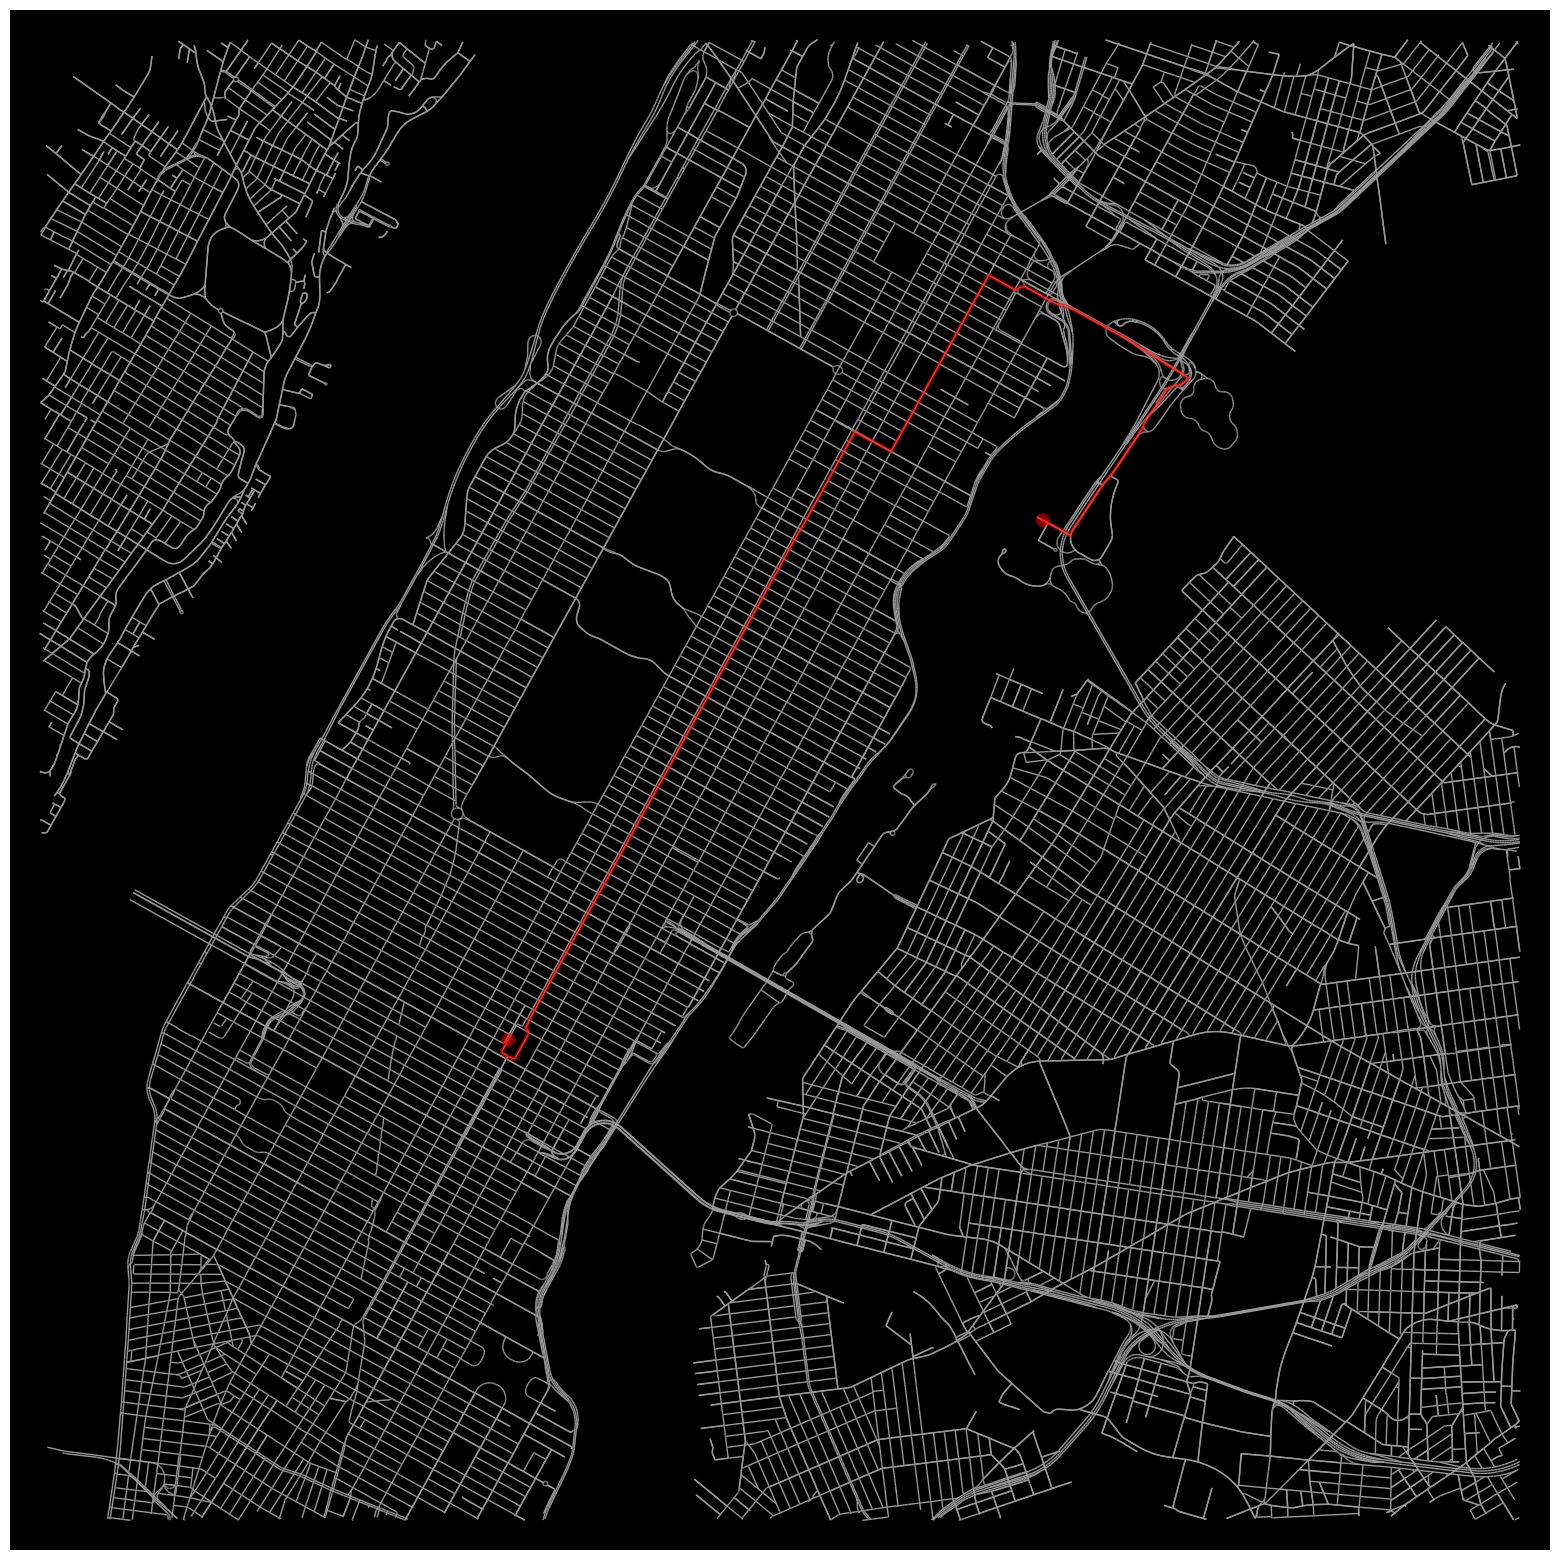

[0.6682494448676273, 0.9316755563689717, 0.8804076481118006, 0.7556192790742013, 0.41485965190194873, 0.143981187683642, -0.3181319492853764, 0.22290107665492023, 0.7276520148144109, 0.7964768389236918]
destination


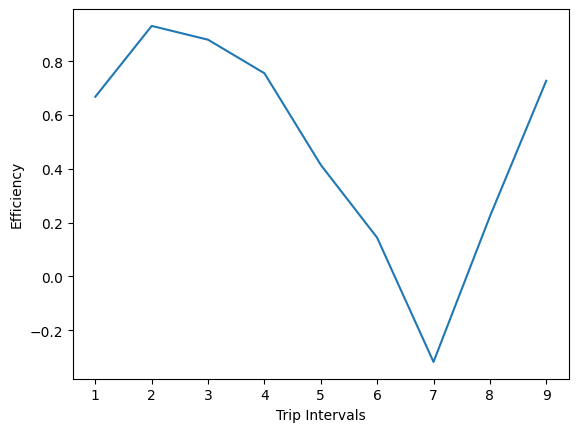

[9673654626, 100521730, 9140654130, 1690448972, 42459083, 9140654131, 1690448973, 9140654132, 100521728, 9140654133, 100521835, 11023021048, 11022425826, 100521834, 11022425830, 11022425827, 11022425831, 8122411163, 11022425828, 1690448976, 11022425829, 11029989171, 100521831, 9140654137, 11506834516, 42459051, 11022425832, 11022425837, 1690448997, 11022425838, 11022425833, 11022425839, 595142277, 11022425834, 11022425840, 3786901755, 11022425835, 1690449001, 11022425836, 3786901756, 11022425841, 100522739, 9140654136, 100522737, 100522736, 3786902257, 1690448974, 3786902258, 9140654135, 9140654134, 3842775636, 11506958668, 3842775634, 3842775640, 3842775641, 3842775633, 7520841184, 3842775635, 10170668447, 11507193237, 11507193224, 10168841852, 10168841853, 11509720175, 10168841855, 10168841856, 10165986955, 10165986958, 10165986956, 10170640346, 10165986966, 10165986964, 10170640113, 10170640112, 10170640111, 10165986980, 10165986983, 10165986981, 10165986988, 3977886188, 10165986989

KeyboardInterrupt: 

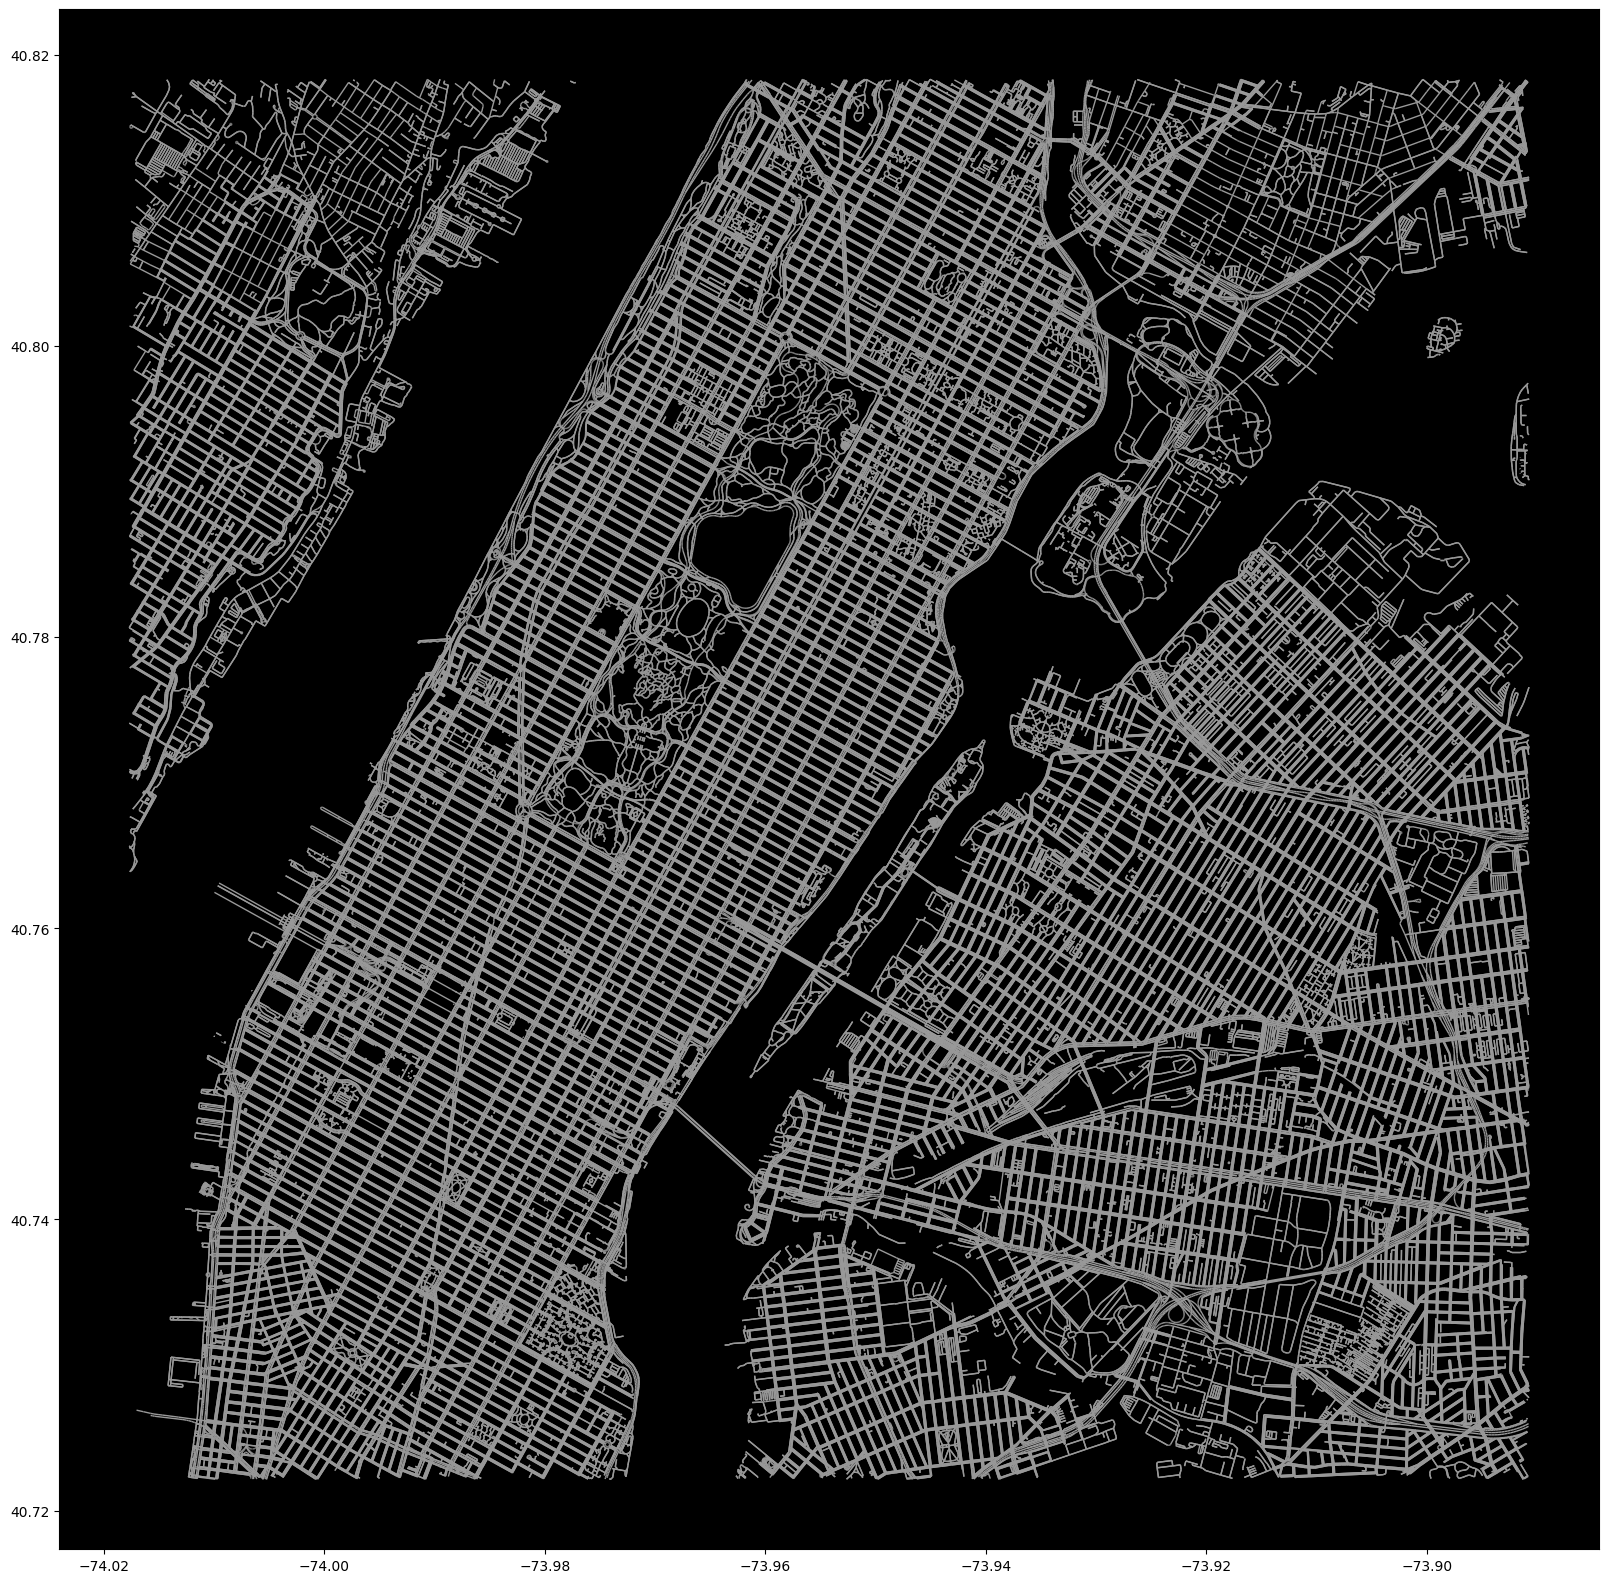

In [31]:
import geopandas as gpd
import heapq
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
from shapely.geometry import Point
import time
import seaborn as sns
    

def main():

    ''' 
    # the current coordinate of user and destionation, (y, x) or (lat, lon)
    current_coordinate = (40.7533560169191, -73.97681356641145) 
    destination_coordinate = (40.78712, -73.93160) # grand central station

    # download the map and convert into graph
    center_point = ((current_coordinate[0] + destination_coordinate[0]) / 2, (current_coordinate[1] + destination_coordinate[1]) / 2)
    euclid_distance = haversine(current_coordinate, destination_coordinate)
    G_driving = ox.graph_from_point(center_point, dist=euclid_distance * 1.5, network_type='drive', retain_all=True, simplify=False) # type: 'MultiDiGraph'

    # find nearest node of O & D
    nearest_node_o, dist_o = find_nearest_node(G_driving, current_coordinate)
    nearest_node_d, dist_d = find_nearest_node(G_driving, destination_coordinate)
    traditional_driving_start = time.time()
    shortest_path_driving = nx.shortest_path(G_driving, nearest_node_o, nearest_node_d, weight='length') # list of int, the list of point num
    traditional_driving_end = time.time()
    print(f'Traditional driving time used: {traditional_driving_end-traditional_driving_start}')
    
    # calculate the traditional shortest path and plot
    shortest_path_driving_length = calculate_path_length(G_driving, shortest_path_driving)
    print(f'The length of driving: {shortest_path_driving_length} meters')
    fig, ax = ox.plot_graph_route(G_driving, shortest_path_driving, route_linewidth=3, node_size=0, bgcolor='k', figsize=(20, 20))
    plt.show()

    # detect the detour
    num = 10
    detour_result = check_detour(G_driving, num, shortest_path_driving)
    print(f'detour detect: {detour_result}')    

    # find the shortest pedstrian path 
    G_walking = ox.graph_from_point(center_point, dist=euclid_distance * 1.5, network_type='all', retain_all=True, simplify=False) # type: 'MultiDiGraph'

    #dij_start = time.time()
    #shortest_path_walking = nx.shortest_path(G_walking, nearest_node_o, nearest_node_d, weight='length') # list of int, the list of point num
    #dij_end = time.time()
    #print(f'dij time used: {dij_end-dij_start}')
    #print(f'it goes through {len(shortest_path_walking)} nodes')    
    #fig, ax = ox.plot_graph_route(G_walking, shortest_path_walking, route_linewidth=3, node_size=0, bgcolor='k', figsize=(20, 20))
    #plt.show()
    
    # parameters: waiting time, speed of walking and driving
    v_walking = 4500 # meter per hr
    v_driving = 30000 # meter per hr
    taxi_waiting_time = 10 / 60 # 5 mins in hr

    a_star_start = time.time()
    meeting_point, walking_path, driving_path = bidirectional_search_single(G_driving, G_walking, nearest_node_d, nearest_node_o, shortest_path_driving_length, v_driving, v_walking, taxi_waiting_time, forward=False)
    a_star_end = time.time()
    print(f'a* time used: {a_star_end-a_star_start}')
    print(f'it goes through {len(walking_path) + len(driving_path)} nodes')
    
    # plot
    fig, ax = ox.plot_graph_routes(G_walking, [walking_path, driving_path], route_colors=['r', 'b'], route_linewidth=3, node_size=0, bgcolor='k', figsize=(20, 20))
    plt.show()
    
    n = 1

    place_name = "New York City, USA"
    G_driving = ox.graph_from_place(place_name, network_type='drive', retain_all=True, simplify=False) # type: 'MultiDiGraph'
    G_walking = ox.graph_from_place(place_name, network_type='walk', retain_all=True, simplify=False) # type: 'MultiDiGraph'
    
    # read data
    data = read_taxi_data(file='NycData.txt')

    # parameters: waiting time, speed of walking and driving
    v_walking = 5000 # meter per hr
    v_driving = 20000 # meter per hr
    taxi_waiting_time = 5 / 60 # 5 mins in hr
    extra_trip_time = 0 # 5 mins in hr

    for index, row in data.iterrows():

        try:

            print(f'===== {n}')

            # the current coordinate of user and destionation, (y, x) or (lat, lon)
            origin = (row['pu_lat'], row['pu_lon'])
            destination = (row['do_lat'], row['do_lon']) 

            # find nearest node of O & D
            nearest_node_o, _ = find_nearest_node(G_driving, origin)
            nearest_node_d, _ = find_nearest_node(G_driving, destination)
            shortest_path_driving = nx.shortest_path(G_driving, nearest_node_o, nearest_node_d, weight='length') # list of int, the list of point num
                    
            # calculate the traditional shortest path and plot
            shortest_path_driving_length = calculate_path_length(G_driving, shortest_path_driving) # meter

            if shortest_path_driving_length == 0:
                print('illegal path length')
                continue
            
            time_used = row['do_time'] - row['pu_time'] # second
            average_speed = shortest_path_driving_length / time_used * 3.6  # kmph

            if average_speed == 0 or average_speed > 60:
                print('illegal speed')
                continue

            num = 10
            detour_result, dis = check_detour(G_driving, num, shortest_path_driving, dis=True)
            print(f'detour result: {detour_result}')

            if detour_result != None:
                p1, n1, p2, n2, p3 = find_trans_points(G_driving, G_walking, nearest_node_o, nearest_node_d, shortest_path_driving_length, v_driving, v_walking, taxi_waiting_time, extra_trip_time, detour_result, dis=dis)
                
                line = f'{n}, {shortest_path_driving_length}, {average_speed}, '  

                if p1 == None: # shortcuts unfound
                    print('shortcut unfound')
                    line += '0, 0, 0, 0, 0, 0'
                elif p3 == None:    # only one side detour      
                    new_driving_path_length = calculate_path_length(G_driving, p2)
                    saved_driving_length = shortest_path_driving_length - new_driving_path_length
                    new_driving_time = new_driving_path_length / average_speed
                    new_walking_path_length = calculate_path_length(G_walking, p1)
                    new_walking_time = new_walking_path_length / v_walking
                    line += f'1, {new_driving_path_length}, {saved_driving_length}, {new_driving_time}, {new_walking_path_length}, {new_walking_time}'
                else:       # both side detour
                    new_driving_path_length = calculate_path_length(G_driving, p2)
                    saved_driving_length = shortest_path_driving_length - new_driving_path_length
                    new_driving_time = new_driving_path_length / average_speed
                    new_walking_path_length = calculate_path_length(G_walking, p1) + calculate_path_length(G_walking, p3)
                    new_walking_time = new_walking_path_length / v_walking
                    line += f'2, {new_driving_path_length}, {saved_driving_length}, {new_driving_time}, {new_walking_path_length}, {new_walking_time}'

            else:
                line = f'{n}, {shortest_path_driving_length}, {average_speed}, -1, 0, 0, 0, 0, 0'   # no detour      
            
            line += '\n'

            with open('NycResult_0.txt', 'a') as file:
                file.write(line)

            n += 1

        except:
            print('error occurs')
    
    '''
     
    # double sides
    #origin = (51.489065767196955, -3.1783395156287892) # abacws
    #destination = (51.48252260590389, -3.188230801655341) # house in park
    origin = (40.7533560169191, -73.97681356641145)
    destination = (40.78712, -73.93160) # grand central station
    euclid_distance = haversine(origin, destination)
    print(euclid_distance)
    
    # download the map and convert into graph
    center_point = ((origin[0] + destination[0]) / 2, (origin[1] + destination[1]) / 2)
    G_driving = ox.graph_from_point(center_point, dist=euclid_distance * 1, network_type='drive', retain_all=True, simplify=False) # type: 'MultiDiGraph'
    G_walking = ox.graph_from_point(center_point, dist=euclid_distance * 1, network_type='all', retain_all=True, simplify=False) # type: 'MultiDiGraph'

    # find nearest node of O & D
    nearest_node_o, dist_o = find_nearest_node(G_driving, origin)
    nearest_node_d, dist_d = find_nearest_node(G_driving, destination)
    traditional_driving_start = time.time()
    shortest_path_driving = nx.shortest_path(G_driving, nearest_node_o, nearest_node_d, weight='length') # list of int, the list of point num
    traditional_driving_end = time.time()
    print(f'traditional driving time used: {traditional_driving_end-traditional_driving_start}')
    
    # calculate the traditional shortest path and plot
    shortest_path_driving_length = calculate_path_length(G_driving, shortest_path_driving)
    # print(shortest_path_driving_length)
    fig, ax = ox.plot_graph_route(G_driving, shortest_path_driving, route_linewidth=3, node_size=0, bgcolor='k', figsize=(20, 20))
    plt.show()
    
    # parameters: waiting time, speed of walking and driving
    v_walking = 5000 # meter per hr
    v_driving = 20000 # meter per hr
    taxi_waiting_time = 10 / 60 # 5 mins in hr
    extra_trip_time = 0 / 60

    num = 10
    detour_result, dis = check_detour(G_driving, num, shortest_path_driving, dis=True)
    print(detour_result)

    
    eff, _ = trip_efficiency(G_walking, num, shortest_path_driving)

    sns.lineplot(x=[1,2,3,4,5,6,7,8,9], y=eff[:-1])
    plt.xlabel('Trip Intervals')
    plt.ylabel('Efficiency')
    plt.show() 

    a = (40.7862189, -73.9399322)
    nearest_node_a, dist_a = find_nearest_node(G_driving, a)
    p1 = nx.shortest_path(G_walking, nearest_node_o, nearest_node_a, weight='length')
    p2 = nx.shortest_path(G_walking, nearest_node_a, nearest_node_d, weight='length')
    print(p1)
    print(p2)

    # plot
    #G = ox.graph_from_point(center_point, dist=euclid_distance * 1, network_type='all', retain_all=True, simplify=False) # type: 'MultiDiGraph'
    fig, ax = ox.plot_graph_routes(G_walking, routes=[p1, p2], route_colors=['r', 'b'], route_linewidth=3, node_size=0, bgcolor='k', figsize=(20, 20))
    plt.show()

    
    
################################################################################


def find_trans_points(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, detour, dis=0.5):
    
    if detour == 'origin':
        p1, n1, p2 = bidirectional_search(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, dis=dis)
        return p1, n1, p2, None, None

    elif detour == 'destination':    
        p1, n1, p2 = bidirectional_search(G_driving, G_walking, destination, origin, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, forward=False, dis=dis)  
        return p1, n1, p2, None, None
    
    elif detour == 'both':

        # origin side shortcut
        p1, n1, p2_temp = bidirectional_search(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, dis=dis[0])
        
        # check availability of origin side shortcut
        if p1 == None or n1 == None or p2_temp == None:
            return None, None, None, None, None
        
        # destination side shortcut
        _, new_dis = check_detour(G_driving, 10, p2_temp, dis=True)        
        p3, n2, p2 = bidirectional_search(G_driving, G_walking, destination, n1, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, forward=False, dis=new_dis)
        
        if p2 == None or n2 == None or p3 == None:
            return p1, n1, p2_temp, None, None
        else:
            return p1, n1, p2, n2, p3
    
    else:
        return None, None, None, None, None
        


################################################################################


def bidirectional_search(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time=0, forward=True, dis=0.5):

    # boundary
    driving_time_boundary = driving_path_length / driving_speed # time used for fully driving
    if forward:
        dis_lim = (1 - dis) * driving_path_length
    else:
        dis_lim = dis * driving_path_length

    # Forward search (walking search)
    walking_priority_queue = [] # priority queue
    heapq.heappush(walking_priority_queue, (0, origin)) 

    walking_came_from = {} # mapping, used to reconstruct the path

    walking_cost_so_far = {} # mapping, record the cost from origin to each node
    walking_cost_so_far[origin] = 0

    # Backward search (driving search)
    driving_priority_queue = []
    heapq.heappush(driving_priority_queue, (0, destination))

    driving_came_from = {}

    driving_cost_so_far = {}
    driving_cost_so_far[destination] = 0

    minimum_cost = float('inf')
    meeting_point_coordinate = None

    # main loop
    while walking_priority_queue or driving_priority_queue:

        # Forward search step (walking search)
        if walking_priority_queue and meeting_point_coordinate != None:
            _, walking_current = heapq.heappop(walking_priority_queue) # pop and return the smallest item from the heap, heap[0] to return without pop
                        
            if walking_current in driving_cost_so_far: # meeting point found in backward driving list
                walking_time = walking_cost_so_far[walking_current] / walking_speed
                driving_time = driving_cost_so_far[walking_current] / driving_speed
                walking_search_current_time = max(walking_time, taxi_waiting_time) + driving_time  # calculate time consumed
                if walking_search_current_time <= (driving_time_boundary + taxi_waiting_time + extra_trip_time):
                    driving_path = reconstruct_path(driving_came_from, destination, walking_current)
                    if forward:
                        driving_path.reverse()
                        standard = (None, 'destination')
                    else:
                        standard = (None, 'origin')    
                    if check_detour(G_driving, 10, driving_path) in standard:
                        walking_path = reconstruct_path(walking_came_from, origin, walking_current)
                        if not forward:
                            walking_path.reverse()
                        return walking_path, walking_current, driving_path[1:]

            # all neighbors of current node
            walking_neighbors = G_walking.neighbors(walking_current) if forward else G_walking.predecessors(walking_current)

            for walking_neighbor in walking_neighbors:
                if forward:
                    walking_new_cost = walking_cost_so_far[walking_current] + G_walking[walking_current][walking_neighbor][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor
                else:
                    walking_new_cost = walking_cost_so_far[walking_current] + G_walking[walking_neighbor][walking_current][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor

                if walking_neighbor not in walking_cost_so_far or walking_new_cost < walking_cost_so_far[walking_neighbor]: # neighbor's cost less than the record in mapping
                    walking_cost_so_far[walking_neighbor] = walking_new_cost
                    walking_priority = walking_new_cost + haversine((G_walking.nodes[walking_neighbor]['y'], G_walking.nodes[walking_neighbor]['x']), meeting_point_coordinate)
                    heapq.heappush(walking_priority_queue, (walking_priority, walking_neighbor))
                    walking_came_from[walking_neighbor] = walking_current 
                          
        # Backward search step (driving search)
        if driving_priority_queue:
            _, driving_current = heapq.heappop(driving_priority_queue) # pop and return the smallest item from the heap, heap[0] to return without pop
            
            if driving_current in walking_cost_so_far:
                walking_time = walking_cost_so_far[driving_current] / walking_speed
                driving_time = driving_cost_so_far[driving_current] / driving_speed
                driving_search_current_time = max(walking_time, taxi_waiting_time) + driving_time # calculate time consumed
                if driving_search_current_time <= (driving_time_boundary + taxi_waiting_time + extra_trip_time):
                    driving_path = reconstruct_path(driving_came_from, destination, driving_current)
                    if forward:
                        driving_path.reverse()
                        standard = (None, 'destination')
                    else:
                        standard = (None, 'origin')  
                    if check_detour(G_driving, 10, driving_path) in standard:
                        walking_path = reconstruct_path(walking_came_from, origin, driving_current)
                        if not forward:
                            walking_path.reverse()
                        return walking_path, driving_current, driving_path[1:]

            # all neighbors of current node            
            driving_neighbors = G_driving.predecessors(driving_current) if forward else G_driving.neighbors(driving_current)

            for driving_neighbor in driving_neighbors:
                if forward:
                    driving_new_cost = driving_cost_so_far[driving_current] + G_driving[driving_neighbor][driving_current][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor
                else:    
                    driving_new_cost = driving_cost_so_far[driving_current] + G_driving[driving_current][driving_neighbor][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor

                if driving_neighbor not in driving_cost_so_far or driving_new_cost < driving_cost_so_far[driving_neighbor]: # neighbor's cost less than the record in mapping 
                    driving_cost_so_far[driving_neighbor] = driving_new_cost
                    driving_priority = driving_new_cost + distance(G_driving, driving_neighbor, origin) 
                    heapq.heappush(driving_priority_queue, (driving_priority, driving_neighbor))
                    driving_came_from[driving_neighbor] = driving_current 

                    if driving_new_cost > dis_lim and driving_priority < minimum_cost:
                        meeting_point_coordinate = (G_driving.nodes[driving_neighbor]['y'], G_driving.nodes[driving_neighbor]['x'])

    return None, None, None
    
    
################################################################################


def bidirectional_search_single(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, forward=True):

    # boundary
    driving_time_boundary = driving_path_length / driving_speed
    euclid_distance = distance(G_driving, origin, destination, type='eucild')

    # Forward search (walking search)
    walking_priority_queue = [] # priority queue
    heapq.heappush(walking_priority_queue, (0, origin)) 

    walking_came_from = {} # mapping, used to reconstruct the path

    walking_cost_so_far = {} # mapping, record the cost from origin to each node
    walking_cost_so_far[origin] = 0

    # Backward search (driving search)
    driving_priority_queue = []
    heapq.heappush(driving_priority_queue, (0, destination))

    driving_came_from = {}

    driving_cost_so_far = {}
    driving_cost_so_far[destination] = 0

    minimum_cost = float('inf')
    meeting_point = None

    # main loop
    while walking_priority_queue or driving_priority_queue:

        # Forward search step (walking search)
        if walking_priority_queue and meeting_point != None:
            _, walking_current = heapq.heappop(walking_priority_queue) # pop and return the smallest item from the heap, heap[0] to return without pop
                        
            if walking_current in driving_cost_so_far: # meeting point found in backward driving list
                walking_search_current_time = max((walking_cost_so_far[walking_current] / walking_speed), taxi_waiting_time) + (driving_cost_so_far[walking_current] / driving_speed)  # calculate time consumed
                if walking_search_current_time <= (driving_time_boundary + taxi_waiting_time):
                    driving_path = reconstruct_path(driving_came_from, destination, walking_current)
                    if forward:
                        driving_path.reverse()
                    if check_detour(G_driving, 10, driving_path) == None:
                        walking_path = reconstruct_path(walking_came_from, origin, walking_current)
                        if not forward:
                            walking_path.reverse()
                        return walking_current, walking_path, driving_path[1:]

            # all neighbors of current node
            walking_neighbors = G_walking.neighbors(walking_current) if forward else G_walking.predecessors(walking_current)

            for walking_neighbor in walking_neighbors:
                if forward:
                    walking_new_cost = walking_cost_so_far[walking_current] + G_walking[walking_current][walking_neighbor][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor
                else:
                    walking_new_cost = walking_cost_so_far[walking_current] + G_walking[walking_neighbor][walking_current][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor

                if walking_neighbor not in walking_cost_so_far or walking_new_cost < walking_cost_so_far[walking_neighbor]: # neighbor's cost less than the record in mapping
                    walking_cost_so_far[walking_neighbor] = walking_new_cost
                    walking_priority = walking_new_cost + distance(G_walking, walking_neighbor, meeting_point, type='euclid') 
                    heapq.heappush(walking_priority_queue, (walking_priority, walking_neighbor))
                    walking_came_from[walking_neighbor] = walking_current 
                          
        # Backward search step (driving search)
        if driving_priority_queue:
            _, driving_current = heapq.heappop(driving_priority_queue) # pop and return the smallest item from the heap, heap[0] to return without pop
            
            if driving_current in walking_cost_so_far:
                driving_search_current_time = max((walking_cost_so_far[driving_current] / walking_speed), taxi_waiting_time) + (driving_cost_so_far[driving_current] / driving_speed)  # calculate time consumed
                if driving_search_current_time <= (driving_time_boundary + taxi_waiting_time):
                    driving_path = reconstruct_path(driving_came_from, destination, driving_current)
                    if forward:
                        driving_path.reverse()
                    if check_detour(G_driving, 10, driving_path) == None:
                        walking_path = reconstruct_path(walking_came_from, origin, driving_current)
                        if not forward:
                            walking_path.reverse()
                        return driving_current, walking_path, driving_path[1:]

            # all neighbors of current node            
            driving_neighbors = G_driving.predecessors(driving_current) if forward else G_driving.neighbors(driving_current)

            for driving_neighbor in driving_neighbors:
                if forward:
                    driving_new_cost = driving_cost_so_far[driving_current] + G_driving[driving_neighbor][driving_current][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor
                else:    
                    driving_new_cost = driving_cost_so_far[driving_current] + G_driving[driving_current][driving_neighbor][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor

                if driving_neighbor not in driving_cost_so_far or driving_new_cost < driving_cost_so_far[driving_neighbor]: # neighbor's cost less than the record in mapping 
                    driving_cost_so_far[driving_neighbor] = driving_new_cost
                    driving_priority = driving_new_cost + distance(G_driving, driving_neighbor, origin, type='euclid') 
                    heapq.heappush(driving_priority_queue, (driving_priority, driving_neighbor))
                    driving_came_from[driving_neighbor] = driving_current 

                    if driving_new_cost > 0.5 * euclid_distance and driving_priority < minimum_cost:
                        meeting_point = driving_neighbor

    return None, None, None


########################################################################################################################################


def reconstruct_path(came_from, start, end):
    path = []
    current = end
    while current in came_from:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path


def distance(G, n1, n2, type='manhattan'):
    lat1, lon1 = G.nodes[n1]['y'], G.nodes[n1]['x']
    lat2, lon2 = G.nodes[n2]['y'], G.nodes[n2]['x']
    if type == 'manhattan':
        return manhattan_distance((lat1, lon1), (lat2, lon2))
    else:
        return haversine((lat1, lon1), (lat2, lon2))


def manhattan_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    R = 6371000
    dlat = R * abs(lat2 - lat1)
    dlon = R * abs(lon2 - lon1) * math.cos((lat1 + lat2) / 2)
    distance = dlat + dlon
    return distance


def haversine(point1, point2): # return distance in meter
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    R = 6371000
    distance = R * c
    return distance


def check_detour(G, num, shortest_path, dis=False):
    eff, _ = trip_efficiency(G, num, shortest_path)
    print(eff)

    origin_detour = False
    destination_detour = False

    a = None
    b = None

    for i in range(len(eff)):
        if eff[i] < 0:
            if (i == 0 and eff[i + 1] < 0.3) or (i == num - 2 and eff[i - 1] < 0.3): # first or last element
                if i == 0: # first element
                    origin_detour = True
                    if a == None:
                        a = i + 1
                else: # last element
                    destination_detour = True
                    b = i + 1
            elif i != 0 and i != num - 2:
                if eff[i + 1] < 0.3 or eff[i - 1] < 0.3:
                    if i < num / 2:
                        origin_detour = True
                        if a == None:
                            a = i + 1
                    elif i > num / 2:
                        destination_detour = True
                        b = i + 1
    
    if origin_detour and destination_detour: # 2 sides detour
        if dis:
            return 'both', (a / (num - 1), b / (num - 1))
        else:    
            return 'both'
    elif origin_detour:
        if dis:
            return 'origin', a / (num - 1)
        else:    
            return 'origin'
    elif destination_detour:
        if dis:
            return 'destination', b / (num - 1)
        else:    
            return 'destination'
    else:
        if dis:
            return None, None
        else:    
            return None


def calculate_path_length(G, path):
    length = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        edge_data = G.get_edge_data(u, v, default={'length': 0})
        length += edge_data.get(0).get('length')
    return length


def find_nearest_node(G, point, G_projected=False):
    if G_projected == False:
        G = ox.project_graph(G)
    x, y = project_coordinate(G, point)
    return ox.distance.nearest_nodes(G, x, y, return_dist=True)


def plot_gdf_graph(gdf):
    fig, ax = plt.subplots(figsize=(20, 20))    
    gdf[0].plot(ax=ax, linewidth=1, edgecolor='black')
    gdf[1].plot(ax=ax, markersize=10, color='red')
    ax.set_title('Street Network', fontsize=15)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)    
    plt.show()


def euclid_distance(G, point1, point2, G_projected=False):
    if G_projected == False:
        G = ox.project_graph(G)
    x1, y1 = project_coordinate(G, point1)
    x2, y2 = project_coordinate(G, point2)
    return ox.distance.euclidean(y1, x1, y2, x2)
    

def project_coordinate(G_projected, point):
    lat, lon = point[0], point[1]
    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")
    gdf_projected = gdf.to_crs(G_projected.graph['crs'])
    projected_point = gdf_projected.geometry.iloc[0]
    return projected_point.x, projected_point.y


def trip_efficiency(G, num, shortest_path, type="point"):
    # result
    efficiency = []
    points = []
    #parameters
    shortest_path_length = calculate_path_length(G, shortest_path)
    segment_length = shortest_path_length / num
    cumulative_distances = 0
    # points
    start_coordinate = (G.nodes[shortest_path[0]]['y'], G.nodes[shortest_path[0]]['x'])
    distination_coordinate = (G.nodes[shortest_path[-1]]['y'], G.nodes[shortest_path[-1]]['x'])
    last_point = shortest_path[0]
    # iterating through all nodes in path
    for i in range(1, len(shortest_path)):
        point = shortest_path[i]
        point_coordinate = (G.nodes[point]['y'], G.nodes[point]['x'])       
        cumulative_distances += G.get_edge_data(last_point, point, default={'length': 0}).get(0).get('length')
        if cumulative_distances >= segment_length:
            efficiency.append((haversine(start_coordinate, distination_coordinate)-haversine(point_coordinate, distination_coordinate))/cumulative_distances)
            if type == "point":
                points.append(point)
            elif type == "coordinate":
                points.append(point_coordinate)
            else:
                pass
            start_coordinate = point_coordinate
            cumulative_distances = 0
        last_point = point 
    if cumulative_distances != 0:      
        efficiency.append(haversine(start_coordinate, distination_coordinate)/cumulative_distances)
    return efficiency, points


if __name__ == '__main__':
    main()


In [ ]:
###################################### 旧金山出租车数据集 ###########################################
''' 
columns = ['taxi_id', 'PU_time', 'PU_latitude', 'PU_longitude','DO_time', 'DO_latitude', 'DO_longitude', 'average_speed', 'path'] (speed: kmph)
'''


import pandas as pd
import datetime
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
import time


def main():

    n = 1
    name_list = get_taxi_names("cabspottingdata\\_cabs.txt")

    place_name = "San Francisco, California, USA"
    G_driving = ox.graph_from_place(place_name, network_type='drive', retain_all=True, simplify=False) # type: 'MultiDiGraph'

    for taxi_id in name_list:
    
        # read data
        data = read_sanfr_taxi(taxi_id)
        trips = extract_trips(data)

        for trip in trips:

            try:
                # the current coordinate of user and destionation, (y, x) or (lat, lon)
                origin = trip['PU_point']
                destination = trip['DO_point'] 

                # find nearest node of O & D
                nearest_node_o, _ = find_nearest_node(G_driving, origin)
                nearest_node_d, _ = find_nearest_node(G_driving, destination)
                shortest_path_driving = nx.shortest_path(G_driving, nearest_node_o, nearest_node_d, weight='length') # list of int, the list of point num
                        
                # calculate the traditional shortest path and plot
                shortest_path_driving_length = calculate_path_length(G_driving, shortest_path_driving)
                time_used = trip['DO_time'] - trip['PU_time']
                average_speed = shortest_path_driving_length / time_used * 3.6  # kmph

                line = taxi_id + '; ' + str(int(trip['PU_time'])) + '; ' + str(origin[0]) + '; ' + str(origin[1]) + '; '
                line += str(int(trip['DO_time'])) + '; ' + str(destination[0]) + '; ' + str(destination[1]) + '; ' + str(average_speed) + '; '

                path = ''
                for point in shortest_path_driving:
                    path += str(point) + ','
                path = path[:-1]

                line += path + '\n'

                with open('SanFrData.txt', 'a') as file:
                    file.write(line)

                print(n)
                n += 1
                
            except:
                print('error occur')

            
         


#######################################################################


def distance(G, n1, n2, type='manhattan'):
    lat1, lon1 = G.nodes[n1]['y'], G.nodes[n1]['x']
    lat2, lon2 = G.nodes[n2]['y'], G.nodes[n2]['x']
    if type == 'manhattan':
        return manhattan_distance((lat1, lon1), (lat2, lon2))
    else:
        return haversine((lat1, lon1), (lat2, lon2))


def manhattan_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    R = 6371000
    dlat = R * abs(lat2 - lat1)
    dlon = R * abs(lon2 - lon1) * math.cos((lat1 + lat2) / 2)
    distance = dlat + dlon
    return distance


def haversine(point1, point2): # return distance in meter
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    R = 6371000
    distance = R * c
    return distance


def calculate_path_length(G, path):
    length = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        edge_data = G.get_edge_data(u, v, default={'length': 0})
        length += edge_data.get(0).get('length')
    return length


def find_nearest_node(G, point, G_projected=False):
    if G_projected == False:
        G = ox.project_graph(G)
    x, y = project_coordinate(G, point)
    return ox.distance.nearest_nodes(G, x, y, return_dist=True)


def project_coordinate(G_projected, point):
    lat, lon = point[0], point[1]
    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")
    gdf_projected = gdf.to_crs(G_projected.graph['crs'])
    projected_point = gdf_projected.geometry.iloc[0]
    return projected_point.x, projected_point.y


#######################################################################


def extract_trips(data):

    trips = []
    trip = dict()
    bool = True

    for index, row in data.iterrows():

        if row['occupancy'] == 1 and bool:
            trip['PU_time'] = row['time']
            trip['PU_point'] = (row['latitude'], row['longitude'])
            bool = False

        elif row['occupancy'] == 0 and trip:
            trip['DO_time'] = row['time']
            trip['DO_point'] = (row['latitude'], row['longitude'])
            trips.append(trip)
            trip = dict()
            bool = True

    # If there's a trip still being recorded when the data ends
    if trip:
        trip['DO_time'] = row['time']
        trip['DO_point'] = (row['latitude'], row['longitude'])
        trips.append(trip)
        trip = dict()
        bool = True

    return trips       


def get_taxi_names(file):
    file_handle = open(file, 'r')
    lines = list()
    for line in file_handle:
        line = line.rstrip()
        id = line.split()[1].split('\"')[1]
        lines.append(id)
    return lines    


def read_sanfr_taxi(taxi_id):
    file = "cabspottingdata\\new_" + taxi_id + ".txt"    
    columns = ['latitude', 'longitude', 'occupancy', 'time']
    data = pd.read_csv(file, sep=' ', header=None, names=columns)
    data = data.sort_values(by='time') # sort by time
    return data


if __name__ == '__main__':
    main()

In [ ]:
def trip_efficiency1(G, num, shortest_path, type="point"):

    # result
    efficiency = []
    points = [shortest_path[0]]

    #parameters
    shortest_path_length = calculate_path_length(G, shortest_path)
    segment_length = shortest_path_length / num
    cumulative_distances = 0

    # points
    start_coordinate = (G.nodes[shortest_path[0]]['y'], G.nodes[shortest_path[0]]['x'])
    distination_coordinate = (G.nodes[shortest_path[-1]]['y'], G.nodes[shortest_path[-1]]['x'])
    last_point = shortest_path[0]

    # iterating through all nodes in path
    for i in range(1, len(shortest_path)):
        point = shortest_path[i]
        point_coordinate = (G.nodes[point]['y'], G.nodes[point]['x'])       
        cumulative_distances += G.get_edge_data(last_point, point, default={'length': 0}).get(0).get('length')
        if cumulative_distances >= segment_length:
            efficiency.append((haversine(start_coordinate, distination_coordinate) - haversine(point_coordinate, distination_coordinate)) / cumulative_distances)
            print(f'e = {(haversine(start_coordinate, distination_coordinate) - haversine(point_coordinate, distination_coordinate)) / cumulative_distances}')
            print(f'ending point is {point}')
            if type == "point":
                points.append(point)
            elif type == "coordinate":
                points.append(point_coordinate)
            else:
                pass
            start_coordinate = point_coordinate
            cumulative_distances = 0
        last_point = point 

    return efficiency, points 


def check_detour(G, num, shortest_path):
    eff, _ = trip_efficiency(G, num, shortest_path)
    print(eff)

    origin_detour = False
    destination_detour = False

    for i in range(num - 1):
        if eff[i] < 0:
            if (i == 0 and eff[i + 1] < 0.3) or (i == num - 2 and eff[i - 1] < 0.3):
                if i == 0:
                    origin_detour = True
                else:
                    destination_detour = True
            elif i != 0 and i != num - 2:
                if eff[i + 1] < 0.3 or eff[i - 1] < 0.3:
                    if i < num / 2:
                        origin_detour = True
                    elif i > num / 2:
                        destination_detour = True
    
    if origin_detour and destination_detour:
        return 'both'
    elif origin_detour:
        return 'origin'
    elif destination_detour:
        return 'destination'
    else:
        return None 



# double sides
origin = (51.489065767196955, -3.1783395156287892) # abacws
destination = (51.48252260590389, -3.188230801655341) # house in park
bus_stop = (51.488474291977084, -3.17894695017101)
church = (51.4816171630368, -3.1881703412677114)

# download the map and convert into graph
euclid_distance = haversine(origin, destination)
center_point = ((origin[0] + destination[0]) / 2, (origin[1] + destination[1]) / 2)
G = ox.graph_from_point(center_point, dist=euclid_distance * 1.5, network_type='drive', retain_all=True, simplify=False) # type: 'MultiDiGraph'

# find nearest node of O & D
nearest_node_o, dist_o = find_nearest_node(G, origin)
nearest_node_d, dist_d = find_nearest_node(G, destination)
nearest_node_bus_stop, dist_bus_stop = find_nearest_node(G, bus_stop)
nearest_node_church, dist_church = find_nearest_node(G, church)

# calculate the traditional shortest path and plot
traditional_driving_start = time.time()
shortest_path_driving = nx.shortest_path(G, nearest_node_o, nearest_node_d, weight='length') # list of int, the list of point num
traditional_driving_end = time.time()
print(f'traditional driving time used: {traditional_driving_end-traditional_driving_start}')
shortest_path_driving_length = calculate_path_length(G, shortest_path_driving)
print(shortest_path_driving_length)
fig, ax = ox.plot_graph_route(G, shortest_path_driving, route_linewidth=3, node_size=0, bgcolor='k', figsize=(20, 20))
plt.show()

shortest_path_driving_o_church = nx.shortest_path(G, nearest_node_o, nearest_node_church, weight='length') # list of int, the list of point num
shortest_path_driving_bus_d = nx.shortest_path(G, nearest_node_bus_stop, nearest_node_d, weight='length') # list of int, the list of point num
shortest_path_driving_church_bus = nx.shortest_path(G, nearest_node_church, nearest_node_bus_stop, weight='length') # list of int, the list of point num

fig, ax = ox.plot_graph_route(G, shortest_path_driving_church_bus, route_linewidth=3, node_size=0, bgcolor='k', figsize=(20, 20))
plt.show()

# detect the detour
num = 10
eff1 = check_detour(G, num, shortest_path_driving)
print(eff1)    

eff2 = check_detour(G, num, shortest_path_driving_o_church)
print(eff2)    

eff3 = check_detour(G, num, shortest_path_driving_bus_d)
print(eff3)    

eff4= check_detour(G, num, shortest_path_driving_church_bus)
print(eff4)






In [ ]:
############################## 深圳出租车数据集 ###################################

import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import leuvenmapmatching as lmm
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher
import datetime

def match_path_to_graph(graph, path):
    map_con = InMemMap("myosm", use_latlon=True, use_rtree=True, index_edges=True)

    nodes_id = list(graph.nodes)
    for node in nodes_id:
        lat = graph.nodes[node]['y']
        lon = graph.nodes[node]['x']
        map_con.add_node(node, (lat, lon))

    edges_id = list(graph.edges)
    for edge in edges_id:
        node_a, node_b = edge[0], edge[1]
        map_con.add_edge(node_a, node_b)
        map_con.add_edge(node_b, node_a)  # Add reverse edge

    map_con.purge()

    matcher = DistanceMatcher(map_con, max_dist=30, obs_noise=20, min_prob_norm=0.5,
                              non_emitting_states=True, only_edges=True)
    states, _ = matcher.match(path)
    nodes = matcher.path_pred_onlynodes

    return states, nodes

# Step 1: Read the data from the file
taxi_id = "enyenewl"
file_path = "2013Shenzhen\\2013Shenzhen.txt" # update with the correct path
columns = ['id', 'time', 'longitude', 'latitude', 'occupancy', 'speed']
data = pd.read_csv(file_path, sep=',', header=None, names=columns)

# Step 2: Sort data by time
data = data.sort_values(by=['id', 'time'])

#for index, row in data.iterrows():
    #print(row['latitude'], row['longitude'], row['occupancy'], datetime.datetime.fromtimestamp(row['time']))


# Step 3: Extract trips (where occupancy == 1)
trips = []
trip = []
id = None
for index, row in data.iterrows():

    if row['id'] != 22223:
        break
        #id = row['id']
        #if current_trip:
        #    trips.append(current_trip)
    else: 
        if row['occupancy'] == 1:
            trip.append((row['latitude'], row['longitude']))
        elif row['occupancy'] == 0 and trip:
            trips.append(trip)
            trip = []

# If there's a trip still being recorded when the data ends
if trip:
    trips.append(trip)


for trip in trips:
    print(trip)

# Step 4: Setup OSM map using osmnx
# G = ox.graph_from_place('Shenzhen, Guangdong, China', network_type='drive')    



''' 

paths = []

for trip in trips:

    print('===before===')
    fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(30, 30), node_size=0)
    # Extract latitude and longitude from the trajectory and plot them on the graph
    traj_lats = [point[0] for point in trip]
    traj_lons = [point[1] for point in trip]
    ax.scatter(traj_lons, traj_lats, c='red', s=10)  # c for color, s for size of points
    plt.show()

    print('===after===')
    try:
        _, nodes = match_path_to_graph(G, trip)
        if nodes:
            paths.append(nodes)
            fig, ax = ox.plot_graph_route(G, nodes, route_linewidth=3, node_size=0, bgcolor='k', figsize=(30, 30))
    except:
        print('unsuccessful')  

print(f'total {len(trips)} trips')
for trip in trips:
    print(f'this trip goes {len(trip)} points')

    fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(30, 30), node_size=0)

    # Extract latitude and longitude from the trajectory and plot them on the graph
    traj_lats = [point[0] for point in trip]
    traj_lons = [point[1] for point in trip]

    ax.scatter(traj_lats, traj_lons, c='red', s=10)  # c for color, s for size of points

    plt.show()

# Step 5: Prepare the map for leuvenmapmatching
# Convert OSMNX graph to a suitable format
m = InMemMap('osm_map', use_latlon=True)

# Loop through each edge in the graph and add it to the map
for u, v, data in G.edges(data=True):
    node_u = G.nodes[u]
    node_v = G.nodes[v]
    # Get coordinates of nodes u and v
    lat_u, lon_u = node_u['y'], node_u['x']
    lat_v, lon_v = node_v['y'], node_v['x']
    # Add edge to the map
    m.add_edge((lat_u, lon_u), (lat_v, lon_v), bidirectional=False)

# Step 6: Perform map matching for each trip
matcher = DistanceMatcher(m, max_dist=200, min_prob_norm=0.001, non_emitting_length_factor=0.95)

for i, trip in enumerate(trips):
    nodes, _ = zip(*matcher.match(trip))
    # Display or process the matched path
    matched_path = [m.edges[n]['path'] for n in nodes]
    print(f"Matched path for trip {i + 1}: {matched_path}")

# Optionally, you can visualize the paths using osmnx's plotting capabilities
import matplotlib.pyplot as plt

for i, path in enumerate(matched_path):
    fig, ax = ox.plot_graph_route(G, path, route_linewidth=3, node_size=0, bgcolor='k', figsize=(20, 20))
    plt.show()
'''    

In [ ]:
import osmnx as ox
import math

def distance(G, n1, n2, type='manhattan'):
    lat1, lon1 = G.nodes[n1]['y'], G.nodes[n1]['x']
    lat2, lon2 = G.nodes[n2]['y'], G.nodes[n2]['x']
    if type == 'manhattan':
        return manhattan_distance((lat1, lon1), (lat2, lon2))
    else:
        return haversine((lat1, lon1), (lat2, lon2))


def manhattan_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    R = 6371000
    dlat = R * abs(lat2 - lat1)
    dlon = R * abs(lon2 - lon1) * math.cos((lat1 + lat2) / 2)
    distance = dlat + dlon
    return distance


def haversine(point1, point2): # return distance in meter
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    R = 6371000
    distance = R * c
    return distance

# the current coordinate of user and destionation, (y, x) or (lat, lon)
origin = (40.7533560169191, -73.97681356641145) 
destination = (40.78712, -73.93160) # grand central station

# download the map and convert into graph
center_point = ((origin[0] + destination[0]) / 2, (origin[1] + destination[1]) / 2)
euclid_distance = haversine(origin, destination)
G_walk = ox.graph_from_point(center_point, dist=euclid_distance * 1.5, network_type='walk', retain_all=True, simplify=False) # type: 'MultiDiGraph'
G_bike = ox.graph_from_point(center_point, dist=euclid_distance * 1.5, network_type='bike', retain_all=True, simplify=False) # type: 'MultiDiGraph'
G = G_walk + G_bike
fig, ax = ox.plot_graph(G, figsize=(30, 30), node_size=0)



In [1]:
###################################### 找行走点 ###########################################

import geopandas as gpd
import heapq
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
from shapely.geometry import Point
import time
import pandas as pd


def main():

    n = 1

    place_name = "San Francisco, California, USA"
    G_driving = ox.graph_from_place(place_name, network_type='drive', retain_all=True, simplify=False) # type: 'MultiDiGraph'
    G_walking = ox.graph_from_place(place_name, network_type='walk', retain_all=True, simplify=False) # type: 'MultiDiGraph'
    
    # read data
    data = read_taxi_data(file='SanFrData.txt')

    # parameters: waiting time, speed of walking and driving
    v_walking = 5000 # meter per hr
    v_driving = 20000 # meter per hr
    taxi_waiting_time = 5 / 60 # 5 mins in hr
    extra_trip_time = 5 / 60 # 5 mins in hr

    for index, row in data.iterrows():

        try:

            print(f'===== {n}')

            # the current coordinate of user and destionation, (y, x) or (lat, lon)
            origin = (row['pu_lat'], row['pu_lon'])
            destination = (row['do_lat'], row['do_lon']) 

            # find nearest node of O & D
            nearest_node_o, _ = find_nearest_node(G_driving, origin)
            nearest_node_d, _ = find_nearest_node(G_driving, destination)
            shortest_path_driving = nx.shortest_path(G_driving, nearest_node_o, nearest_node_d, weight='length') # list of int, the list of point num
                    
            # calculate the traditional shortest path and plot
            shortest_path_driving_length = calculate_path_length(G_driving, shortest_path_driving) # meter

            if shortest_path_driving_length == 0:
                print('illegal path length')
                continue
            
            time_used = row['do_time'] - row['pu_time'] # second
            average_speed = shortest_path_driving_length / time_used * 3.6  # kmph

            if average_speed == 0 or average_speed > 60:
                print('illegal speed')
                continue

            num = 10
            detour_result, dis = check_detour(G_driving, num, shortest_path_driving, dis=True)
            print(f'detour result: {detour_result}')

            if detour_result != None:
                p1, n1, p2, n2, p3 = find_trans_points(G_driving, G_walking, nearest_node_o, nearest_node_d, shortest_path_driving_length, v_driving, v_walking, taxi_waiting_time, extra_trip_time, detour_result, dis=dis)
                
                line = f'{n}, {shortest_path_driving_length}, {average_speed}, '  

                if p1 == None: # shortcuts unfound
                    print('shortcut unfound')
                    line += '0, 0, 0, 0, 0, 0'
                elif p3 == None:    # only one side detour      
                    new_driving_path_length = calculate_path_length(G_driving, p2)
                    saved_driving_length = shortest_path_driving_length - new_driving_path_length
                    new_driving_time = new_driving_path_length / average_speed
                    new_walking_path_length = calculate_path_length(G_walking, p1)
                    new_walking_time = new_walking_path_length / v_walking
                    line += f'1, {new_driving_path_length}, {saved_driving_length}, {new_driving_time}, {new_walking_path_length}, {new_walking_time}'
                else:       # both side detour
                    new_driving_path_length = calculate_path_length(G_driving, p2)
                    saved_driving_length = shortest_path_driving_length - new_driving_path_length
                    new_driving_time = new_driving_path_length / average_speed
                    new_walking_path_length = calculate_path_length(G_walking, p1) + calculate_path_length(G_walking, p3)
                    new_walking_time = new_walking_path_length / v_walking
                    line += f'2, {new_driving_path_length}, {saved_driving_length}, {new_driving_time}, {new_walking_path_length}, {new_walking_time}'

            else:
                line = f'{n}, {shortest_path_driving_length}, {average_speed}, -1, 0, 0, 0, 0, 0'   # no detour      
            
            line += '\n'

            #with open('NycResult_0.txt', 'a') as file:
            #    file.write(line)

            n += 1

        except:
            print('error occurs')

    
    
################################################################################


def find_trans_points(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, detour, dis=0.5):
    
    if detour == 'origin':
        p1, n1, p2 = bidirectional_search(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, dis=dis)
        return p1, n1, p2, None, None

    elif detour == 'destination':    
        p1, n1, p2 = bidirectional_search(G_driving, G_walking, destination, origin, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, forward=False, dis=dis)  
        return p1, n1, p2, None, None
    
    elif detour == 'both':

        # origin side shortcut
        p1, n1, p2_temp = bidirectional_search(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, dis=dis[0])
        
        # check availability of origin side shortcut
        if p1 == None or n1 == None or p2_temp == None:
            return None, None, None, None, None
        
        # destination side shortcut
        _, new_dis = check_detour(G_driving, 10, p2_temp, dis=True)        
        p3, n2, p2 = bidirectional_search(G_driving, G_walking, destination, n1, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time, forward=False, dis=new_dis)
        
        if p2 == None or n2 == None or p3 == None:
            return p1, n1, p2_temp, None, None
        else:
            return p1, n1, p2, n2, p3
    
    else:
        return None, None, None, None, None
        


################################################################################


def bidirectional_search(G_driving, G_walking, origin, destination, driving_path_length, driving_speed, walking_speed, taxi_waiting_time, extra_trip_time=0, forward=True, dis=0.5):

    # boundary
    driving_time_boundary = driving_path_length / driving_speed # time used for fully driving
    if forward:
        dis_lim = (1 - dis) * driving_path_length
    else:
        dis_lim = dis * driving_path_length

    # Forward search (walking search)
    walking_priority_queue = [] # priority queue
    heapq.heappush(walking_priority_queue, (0, origin)) 

    walking_came_from = {} # mapping, used to reconstruct the path

    walking_cost_so_far = {} # mapping, record the cost from origin to each node
    walking_cost_so_far[origin] = 0

    # Backward search (driving search)
    driving_priority_queue = []
    heapq.heappush(driving_priority_queue, (0, destination))

    driving_came_from = {}

    driving_cost_so_far = {}
    driving_cost_so_far[destination] = 0

    minimum_cost = float('inf')
    meeting_point_coordinate = None

    # main loop
    while walking_priority_queue or driving_priority_queue:

        # Forward search step (walking search)
        if walking_priority_queue and meeting_point_coordinate != None:
            _, walking_current = heapq.heappop(walking_priority_queue) # pop and return the smallest item from the heap, heap[0] to return without pop
                        
            if walking_current in driving_cost_so_far: # meeting point found in backward driving list
                walking_time = walking_cost_so_far[walking_current] / walking_speed
                driving_time = driving_cost_so_far[walking_current] / driving_speed
                walking_search_current_time = max(walking_time, taxi_waiting_time) + driving_time  # calculate time consumed
                if walking_search_current_time <= (driving_time_boundary + taxi_waiting_time + extra_trip_time):
                    driving_path = reconstruct_path(driving_came_from, destination, walking_current)
                    if forward:
                        driving_path.reverse()
                        standard = (None, 'destination')
                    else:
                        standard = (None, 'origin')    
                    if check_detour(G_driving, 10, driving_path) in standard:
                        walking_path = reconstruct_path(walking_came_from, origin, walking_current)
                        if not forward:
                            walking_path.reverse()
                        return walking_path, walking_current, driving_path[1:]

            # all neighbors of current node
            walking_neighbors = G_walking.neighbors(walking_current) if forward else G_walking.predecessors(walking_current)

            for walking_neighbor in walking_neighbors:
                if forward:
                    walking_new_cost = walking_cost_so_far[walking_current] + G_walking[walking_current][walking_neighbor][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor
                else:
                    walking_new_cost = walking_cost_so_far[walking_current] + G_walking[walking_neighbor][walking_current][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor

                if walking_neighbor not in walking_cost_so_far or walking_new_cost < walking_cost_so_far[walking_neighbor]: # neighbor's cost less than the record in mapping
                    walking_cost_so_far[walking_neighbor] = walking_new_cost
                    walking_priority = walking_new_cost + haversine((G_walking.nodes[walking_neighbor]['y'], G_walking.nodes[walking_neighbor]['x']), meeting_point_coordinate)
                    heapq.heappush(walking_priority_queue, (walking_priority, walking_neighbor))
                    walking_came_from[walking_neighbor] = walking_current 
                          
        # Backward search step (driving search)
        if driving_priority_queue:
            _, driving_current = heapq.heappop(driving_priority_queue) # pop and return the smallest item from the heap, heap[0] to return without pop
            
            if driving_current in walking_cost_so_far:
                walking_time = walking_cost_so_far[driving_current] / walking_speed
                driving_time = driving_cost_so_far[driving_current] / driving_speed
                driving_search_current_time = max(walking_time, taxi_waiting_time) + driving_time # calculate time consumed
                if driving_search_current_time <= (driving_time_boundary + taxi_waiting_time + extra_trip_time):
                    driving_path = reconstruct_path(driving_came_from, destination, driving_current)
                    if forward:
                        driving_path.reverse()
                        standard = (None, 'destination')
                    else:
                        standard = (None, 'origin')  
                    if check_detour(G_driving, 10, driving_path) in standard:
                        walking_path = reconstruct_path(walking_came_from, origin, driving_current)
                        if not forward:
                            walking_path.reverse()
                        return walking_path, driving_current, driving_path[1:]

            # all neighbors of current node            
            driving_neighbors = G_driving.predecessors(driving_current) if forward else G_driving.neighbors(driving_current)

            for driving_neighbor in driving_neighbors:
                if forward:
                    driving_new_cost = driving_cost_so_far[driving_current] + G_driving[driving_neighbor][driving_current][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor
                else:    
                    driving_new_cost = driving_cost_so_far[driving_current] + G_driving[driving_current][driving_neighbor][0]['length'] # neighbor's cost = origin_to_current + current_to_neighbor

                if driving_neighbor not in driving_cost_so_far or driving_new_cost < driving_cost_so_far[driving_neighbor]: # neighbor's cost less than the record in mapping 
                    driving_cost_so_far[driving_neighbor] = driving_new_cost
                    driving_priority = driving_new_cost + distance(G_driving, driving_neighbor, origin) 
                    heapq.heappush(driving_priority_queue, (driving_priority, driving_neighbor))
                    driving_came_from[driving_neighbor] = driving_current 

                    if driving_new_cost > dis_lim and driving_priority < minimum_cost:
                        meeting_point_coordinate = (G_driving.nodes[driving_neighbor]['y'], G_driving.nodes[driving_neighbor]['x'])

    return None, None, None


########################################################################################################################################


def reconstruct_path(came_from, start, end):
    path = []
    current = end
    while current in came_from:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path


def distance(G, n1, n2, dis_type='manhattan'):
    if type(n1) == tuple:
        lat1, lon1 = n1
    else:    
        lat1, lon1 = G.nodes[n1]['y'], G.nodes[n1]['x']
    if type(n2) == tuple:
        lat2, lon2 = n2
    else:     
        lat2, lon2 = G.nodes[n2]['y'], G.nodes[n2]['x']
    if dis_type == 'manhattan':
        return manhattan_distance((lat1, lon1), (lat2, lon2))
    else:
        return haversine((lat1, lon1), (lat2, lon2))


def manhattan_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    R = 6371000
    dlat = R * abs(lat2 - lat1)
    dlon = R * abs(lon2 - lon1) * math.cos((lat1 + lat2) / 2)
    distance = dlat + dlon
    return distance


def haversine(point1, point2): # return distance in meter
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    R = 6371000
    distance = R * c
    return distance


def check_detour(G, num, shortest_path, dis=False):
    eff, _ = trip_efficiency(G, num, shortest_path)

    origin_detour = False
    destination_detour = False

    a = None
    b = None

    for i in range(len(eff)):
        if eff[i] < 0:
            if (i == 0 and eff[i + 1] < 0.3) or (i == num - 2 and eff[i - 1] < 0.3): # first or last element
                if i == 0: # first element
                    origin_detour = True
                    if a == None:
                        a = i + 1
                else: # last element
                    destination_detour = True
                    b = i + 1
            elif i != 0 and i != num - 2:
                if eff[i + 1] < 0.3 or eff[i - 1] < 0.3:
                    if i < num / 2:
                        origin_detour = True
                        if a == None:
                            a = i + 1
                    elif i > num / 2:
                        destination_detour = True
                        b = i + 1
    
    if origin_detour and destination_detour: # 2 sides detour
        if dis:
            return 'both', (a / (num - 1), b / (num - 1))
        else:    
            return 'both'
    elif origin_detour:
        if dis:
            return 'origin', a / (num - 1)
        else:    
            return 'origin'
    elif destination_detour:
        if dis:
            return 'destination', b / (num - 1)
        else:    
            return 'destination'
    else:
        if dis:
            return None, None
        else:    
            return None


def calculate_path_length(G, path):
    length = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        edge_data = G.get_edge_data(u, v, default={'length': 0})
        length += edge_data.get(0).get('length')
    return length


def find_nearest_node(G, point, G_projected=False):
    if G_projected == False:
        G = ox.project_graph(G)
    x, y = project_coordinate(G, point)
    return ox.distance.nearest_nodes(G, x, y, return_dist=True)


def plot_gdf_graph(gdf):
    fig, ax = plt.subplots(figsize=(20, 20))    
    gdf[0].plot(ax=ax, linewidth=1, edgecolor='black')
    gdf[1].plot(ax=ax, markersize=10, color='red')
    ax.set_title('Street Network', fontsize=15)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)    
    plt.show()
    

def project_coordinate(G_projected, point):
    lat, lon = point[0], point[1]
    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")
    gdf_projected = gdf.to_crs(G_projected.graph['crs'])
    projected_point = gdf_projected.geometry.iloc[0]
    return projected_point.x, projected_point.y


def trip_efficiency(G, num, shortest_path, type="point"):
    # result
    efficiency = []
    points = []
    #parameters
    shortest_path_length = calculate_path_length(G, shortest_path)
    segment_length = shortest_path_length / num
    cumulative_distances = 0
    # points
    start_coordinate = (G.nodes[shortest_path[0]]['y'], G.nodes[shortest_path[0]]['x'])
    distination_coordinate = (G.nodes[shortest_path[-1]]['y'], G.nodes[shortest_path[-1]]['x'])
    last_point = shortest_path[0]
    # iterating through all nodes in path
    for i in range(1, len(shortest_path)):
        point = shortest_path[i]
        point_coordinate = (G.nodes[point]['y'], G.nodes[point]['x'])       
        cumulative_distances += G.get_edge_data(last_point, point, default={'length': 0}).get(0).get('length')
        if cumulative_distances >= segment_length:
            efficiency.append((haversine(start_coordinate, distination_coordinate)-haversine(point_coordinate, distination_coordinate))/cumulative_distances)
            if type == "point":
                points.append(point)
            elif type == "coordinate":
                points.append(point_coordinate)
            else:
                pass
            start_coordinate = point_coordinate
            cumulative_distances = 0
        last_point = point 
    if cumulative_distances != 0:      
        efficiency.append(haversine(start_coordinate, distination_coordinate)/cumulative_distances)
    return efficiency, points


def read_taxi_data(file):
    columns = ['id', 'pu_time', 'pu_lat', 'pu_lon', 'do_time', 'do_lat', 'do_lon']
    data = pd.read_csv(file, sep=';', header=None, names=columns)
    return data


if __name__ == '__main__':
    main()

===== 1
illegal speed
===== 1
detour result: None
===== 2
detour result: None
===== 3
detour result: None
===== 4
detour result: None
===== 5
detour result: None
===== 6
detour result: None
===== 7
detour result: None
===== 8
detour result: None
===== 9
detour result: None
===== 10
detour result: None
===== 11
detour result: None
===== 12
detour result: origin
shortcut unfound
===== 13
detour result: None
===== 14
detour result: None
===== 15
detour result: None
===== 16
detour result: None
===== 17
detour result: None
===== 18
detour result: None
===== 19
detour result: None
===== 20
detour result: None
===== 21
detour result: None
===== 22
detour result: None
===== 23
detour result: None
===== 24
detour result: None
===== 25
detour result: None
===== 26
detour result: None
===== 27
detour result: None
===== 28
error occurs
===== 28
detour result: None
===== 29
detour result: None
===== 30
detour result: None
===== 31
detour result: None
===== 32
detour result: None
===== 33
detour re

In [ ]:
###################################### 出租车数据集分析 ###########################################

''' 
columns = ['taxi_id', 'PU_time', 'PU_latitude', 'PU_longitude','DO_time', 'DO_latitude', 'DO_longitude', 'average_speed', 'path'] (speed: kmph)
'''


import datetime
from datetime import datetime
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
import datetime
import pandas as pd
import seaborn as sns


def main():

    n = 1

    place_name = "Chengdu, Sichuan, China"
    G_driving = ox.graph_from_place(place_name, network_type='drive', retain_all=True, simplify=False) # type: 'MultiDiGraph'
    
    # read data
    data = read_taxi_data(file='ChengduData140803.txt')

    length = []
    speed = []

    for index, row in data.iterrows():

        if n == 401:
            break

        try:

            # the current coordinate of user and destionation, (y, x) or (lat, lon)
            origin = (row['pu_lat'], row['pu_lon'])
            destination = (row['do_lat'], row['do_lon']) 

            # find nearest node of O & D
            nearest_node_o, _ = find_nearest_node(G_driving, origin)
            nearest_node_d, _ = find_nearest_node(G_driving, destination)
            shortest_path_driving = nx.shortest_path(G_driving, nearest_node_o, nearest_node_d, weight='length') # list of int, the list of point num
                    
            # calculate the traditional shortest path and plot
            shortest_path_driving_length = calculate_path_length(G_driving, shortest_path_driving) # meter

            if shortest_path_driving_length == 0:
                continue
            
            time_used = row['do_time'] - row['pu_time'] # second
            average_speed = shortest_path_driving_length / time_used * 3.6  # kmph

            if average_speed == 0 or average_speed > 90:
                continue

            length.append(shortest_path_driving_length)
            speed.append(average_speed)

            eff, _ = trip_efficiency(G_driving, 10, shortest_path_driving)

            line = str(time_used) + ', ' + str(average_speed) + ', ['

            for e in eff:
                line += str(e) + ';'

            line = line[:-1] + ']\n'

            with open('ChengduAnalyze.txt', 'a') as file:
                file.write(line)

            print(n)
            n += 1

        except:
            print('error occurs')    

    average_length = average(length)
    std_dev_length = standard_deviation(length)
    print(f'the average length of trip is {average_length}, with a std. dev. of {std_dev_length}')


    sns.kdeplot(length)
    plt.xlabel('Length')
    plt.ylabel('Probability density')
    plt.show()   


    average_speed = average(speed)
    std_dev_speed = standard_deviation(speed)
    print(f'the average speed of trip is {average_speed}, with a std. dev. of {std_dev_speed}')


    sns.kdeplot(speed)
    plt.xlabel('Speed')
    plt.ylabel('Probability density')
    plt.show()  


#######################################################################


def average(lst):
    return sum(lst) / len(lst) if lst else 0


def standard_deviation(lst):
    if len(lst) < 2:
        return 0
    mean = sum(lst) / len(lst)
    variance = sum((x - mean) ** 2 for x in lst) / (len(lst) - 1)
    return math.sqrt(variance)


def distance(G, n1, n2, type='manhattan'):
    lat1, lon1 = G.nodes[n1]['y'], G.nodes[n1]['x']
    lat2, lon2 = G.nodes[n2]['y'], G.nodes[n2]['x']
    if type == 'manhattan':
        return manhattan_distance((lat1, lon1), (lat2, lon2))
    else:
        return haversine((lat1, lon1), (lat2, lon2))


def manhattan_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    R = 6371000
    dlat = R * abs(lat2 - lat1)
    dlon = R * abs(lon2 - lon1) * math.cos((lat1 + lat2) / 2)
    distance = dlat + dlon
    return distance


def haversine(point1, point2): # return distance in meter
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    R = 6371000
    distance = R * c
    return distance


def calculate_path_length(G, path):
    length = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        edge_data = G.get_edge_data(u, v, default={'length': 0})
        length += edge_data.get(0).get('length')
    return length


def find_nearest_node(G, point, G_projected=False):
    if G_projected == False:
        G = ox.project_graph(G)
    x, y = project_coordinate(G, point)
    return ox.distance.nearest_nodes(G, x, y, return_dist=True)


def project_coordinate(G_projected, point):
    lat, lon = point[0], point[1]
    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")
    gdf_projected = gdf.to_crs(G_projected.graph['crs'])
    projected_point = gdf_projected.geometry.iloc[0]
    return projected_point.x, projected_point.y

def trip_efficiency(G, num, shortest_path, type="point"):
    # result
    efficiency = []
    points = []
    #parameters
    shortest_path_length = calculate_path_length(G, shortest_path)
    segment_length = shortest_path_length / num
    cumulative_distances = 0
    # points
    start_coordinate = (G.nodes[shortest_path[0]]['y'], G.nodes[shortest_path[0]]['x'])
    distination_coordinate = (G.nodes[shortest_path[-1]]['y'], G.nodes[shortest_path[-1]]['x'])
    last_point = shortest_path[0]
    # iterating through all nodes in path
    for i in range(1, len(shortest_path)):
        point = shortest_path[i]
        point_coordinate = (G.nodes[point]['y'], G.nodes[point]['x'])       
        cumulative_distances += G.get_edge_data(last_point, point, default={'length': 0}).get(0).get('length')
        if cumulative_distances >= segment_length:
            efficiency.append((haversine(start_coordinate, distination_coordinate)-haversine(point_coordinate, distination_coordinate))/cumulative_distances)
            if type == "point":
                points.append(point)
            elif type == "coordinate":
                points.append(point_coordinate)
            else:
                pass
            start_coordinate = point_coordinate
            cumulative_distances = 0
        last_point = point 
    if cumulative_distances != 0:      
        efficiency.append(haversine(start_coordinate, distination_coordinate)/cumulative_distances)
    return efficiency, points


#######################################################################
 

def read_taxi_data(file):
    columns = ['id', 'pu_time', 'pu_lat', 'pu_lon', 'do_time', 'do_lat', 'do_lon']
    data = pd.read_csv(file, sep=';', header=None, names=columns)
    return data


def convert_into_UNIX(time_str):
    format_str = "%Y/%m/%d %H:%M:%S"
    dt_obj = datetime.strptime(time_str, format_str)
    return int(dt_obj.timestamp())


if __name__ == '__main__':
    main()

288
317
337


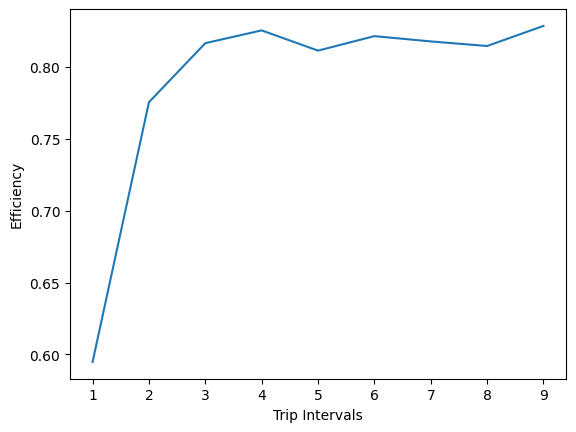

In [39]:
################################# 行程效率分析 #############################

def read_taxi_data(file):
    columns = ['length', 'speed', 'eff']
    data = pd.read_csv(file, sep=',', header=None, names=columns)
    return data


data = read_taxi_data(file='Analyze\\ChengduAnalyze.txt')

count1 = 0
ave_eff = [0,0,0,0,0,0,0,0,0]

for index, row in data.iterrows():

    if row['length'] > 100 and row['speed'] > 0:

        eff = row['eff'][2:-1].split(';') # list of str
        if len(eff) == 9 or len(eff) == 10:
            count1 += 1
            for i in range(9):
                ave_eff[i] += float(eff[i])

print(count1)  

data = read_taxi_data(file='Analyze\\NycAnalyze.txt')

count2 = 0

for index, row in data.iterrows():

    if row['length'] > 100 and row['speed'] > 0:

        eff = row['eff'][2:-1].split(';') # list of str
        if len(eff) == 9 or len(eff) == 10:
            count2 += 1
            for i in range(9):
                ave_eff[i] += float(eff[i])

print(count2)  

data = read_taxi_data(file='Analyze\\SanFrAnalyze.txt')

count3 = 0

for index, row in data.iterrows():

    if row['length'] > 100 and row['speed'] > 0:

        eff = row['eff'][2:-1].split(';') # list of str
        if len(eff) == 9 or len(eff) == 10:
            count3 += 1
            for i in range(9):
                ave_eff[i] += float(eff[i])

print(count3)  

count = count1+count2+count3

result = []
for e in ave_eff:
    result.append(e/count)    

sns.lineplot(x=[1,2,3,4,5,6,7,8,9], y=result)
plt.xlabel('Trip Intervals')
plt.ylabel('Efficiency')
plt.show()  